In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as sps
from numba import jit
from scipy import stats

sys.path.append("../")

In [3]:
import lusim as sim
import network as nn
import objective as obj
import optimize as opt
import project_utilities as utils
from draw_neural_net import draw_neural_net, draw_weighted_neural_net, get_rgb

In [4]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [5]:
rng = np.random.default_rng(seed=6875)

# Grid Definition

In [6]:
nx = 56  # makes nice numbers for convolutions
ny = 56
x0 = 0.5
y0 = 0.5
dx = 1
dy = 1
nxy = nx * ny

X, Y = np.meshgrid(
    np.linspace(x0, x0 + (nx - 1) * dx, nx),
    np.linspace(y0, y0 + (ny - 1) * dy, ny),
)
P = np.concatenate((X.reshape(nxy, 1), Y.reshape(nxy, 1)), axis=1)

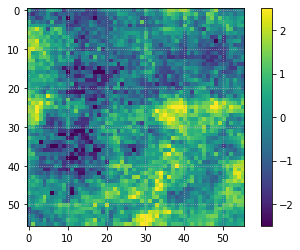

In [7]:
# load target mixture for reference
reference = np.load("../Factor Mixing 2D/mixture_2D.npy").reshape(ny, nx)
im = plt.imshow(reference, vmin=-2.5, vmax=2.5)
plt.colorbar(im)

# Sample Drillholes

In [8]:
ndh = 10
ncomps = ny
dh = np.zeros(ncomps)
var = "var"
dhid = "dhid"
comps = pd.DataFrame(index=np.arange(ndh * ncomps), columns=[var])
comps[dhid] = np.repeat(np.arange(ndh), ncomps)
idxs = np.linspace(nx / ndh, nx - (nx / ndh), ndh, dtype=int)
for i in range(ndh):
    comps.loc[comps[dhid] == i, var] = reference[:, idxs[i]]
    comps.loc[comps[dhid] == i, "X"] = idxs[i]
    comps.loc[comps[dhid] == i, "Y"] = np.arange(1, ny + 1)[::-1]
comps = comps[[dhid, "X", "Y", var]]
comps = comps.astype({var: float})
dhids = comps[dhid].values

In [9]:
comps.head()

,dhid,X,Y,var
0,0,5.0,56.0,0.274784
1,0,5.0,55.0,0.062787
2,0,5.0,54.0,0.030778
3,0,5.0,53.0,-1.125156
4,0,5.0,52.0,-0.158525


In [10]:
dh_lens = []
for uid in comps[dhid].unique():
    dh_lens.append(len(comps.loc[comps[dhid] == uid]))
maxdhlen = max(dh_lens)
ndh = len(dh_lens)
print(ndh, maxdhlen)

10 56


Text(0, 0.5, 'Y (px)')

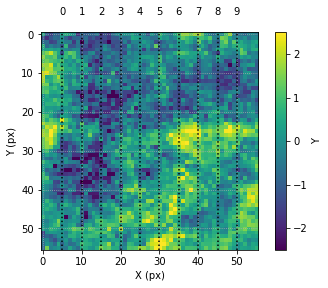

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(reference, vmin=-2.5, vmax=2.5)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Y")
for i, idx in enumerate(idxs):
    ax.axvline(idx, ls=":", c="k")
    ax.text(idx, -5, f"{i}", ha="center")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")

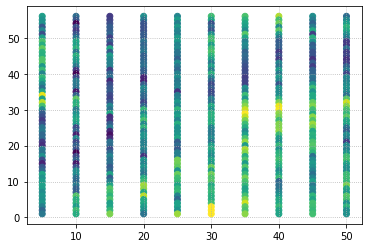

In [12]:
plt.scatter(comps["X"], comps["Y"], c=comps[var], vmin=-2.5, vmax=2.5)
# plt.axis("scaled")

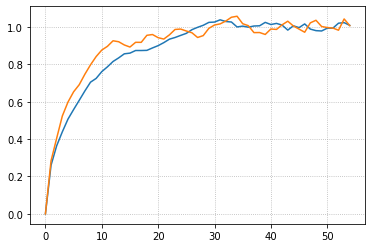

In [13]:
def griddedgam(z):
    """gridded variogram values along x and y axes"""
    nx = z.shape[0]
    ny = z.shape[1]

    gx = np.zeros(nx - 1)
    for i in range(1, nx - 1):
        z0 = z[:, 0 : nx - i]
        z1 = z[:, i:nx]
        dz = (z1 - z0) ** 2
        gx[i] = np.sum(dz) / (2 * (nx - i) * ny)

    gy = np.zeros(ny - 1)
    for i in range(1, ny - 1):
        z0 = z[0 : ny - i, :]
        z1 = z[i:ny, :]
        dz = (z1 - z0) ** 2
        gy[i] = np.sum(dz) / (2 * (ny - i) * nx)

    return [gx, gy]


gx, gy = griddedgam(reference)
plt.plot(gx)
plt.plot(gy)

# Continous Variogram

In [14]:
vtype_t = [1, 2, 1, 1]
xranges_t = [5, 10, 25, 35]
yranges_t = [5, 7, 10, 30]
c0 = 0.1
cc = [0.2, 0.2, 0.2, 0.3]
cmax = c0 + np.sum(cc)
nst = len(vtype_t)

In [15]:
cova = np.zeros((nxy, nxy))
for i in range(nst):
    Q = P.copy()
    Q[:, 0] = Q[:, 0] / xranges_t[i]
    Q[:, 1] = Q[:, 1] / yranges_t[i]
    d = sps.distance_matrix(Q, Q)
    cova = cova + cc[i] * sim.covar(vtype_t[i], d, r=1)
cova[d < 1e-5] = cmax

In [16]:
target_x = 1 - cova[0:nx, 0]
target_y = 1 - cova[0 : nx * ny : ny, 0]

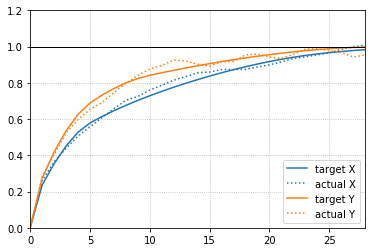

In [17]:
fig, ax = plt.subplots()
ax.plot(target_x, label="target X", c="C0")
ax.plot(gx, ls=":", label="actual X", c="C0")
ax.plot(target_y, label="target Y", c="C1")
ax.plot(gy, ls=":", label="actual Y", c="C1")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.50)
ax.legend(loc=4)

# Indicator Variograms

In [18]:
def indicator_transform(z, zc):
    """indicator transform of z based on cutoffs zc"""
    z = z.flatten()
    zi = np.zeros((len(z), len(zc)))
    ivars = []
    for j, c in enumerate(zc):
        zi[:, j] = np.where(z <= c, 1, 0)
        iprop = np.mean(zi[:, j])
        ivars.append(iprop * (1 - iprop))
    return zi, ivars

In [19]:
quantiles = [0.1, 0.5, 0.9]
thresholds = {q: t for q, t in zip(quantiles, stats.norm.ppf(quantiles))}
thresholds

{0.1: -1.2815515655446004, 0.5: 0.0, 0.9: 1.2815515655446004}

In [20]:
ireference, ivars = indicator_transform(reference, thresholds.values())

In [21]:
vtype_it = [[1, 1], [2, 2], [1, 2]]
xranges_it = [[4, 12], [2, 25], [1, 15]]
yranges_it = [[2, 10], [2, 20], [1, 10]]
cc_i = [[0.7, 0.3], [0.4, 0.6], [0.35, 0.65]]
nst_i = len(vtype_it[0])

In [22]:
icovas = {q: np.zeros((nxy, nxy)) for q in quantiles}
for i, q in enumerate(quantiles):
    for j in range(nst_i):
        Q = P.copy()
        Q[:, 0] = Q[:, 0] / xranges_it[i][j]
        Q[:, 1] = Q[:, 1] / yranges_it[i][j]
        d = sps.distance_matrix(Q, Q)
        icovas[q] = icovas[q] + cc_i[i][j] * sim.covar(vtype_it[i][j], d, r=1)

In [84]:
ivarios = {q: [] for q in thresholds}
for q in quantiles:
    ivarios[q].append(1 - icovas[q][0:nx, 0])
    ivarios[q].append(1 - icovas[q][0 : nx * ny : ny, 0])
    ivarios[q].append([]) # empty vert direction

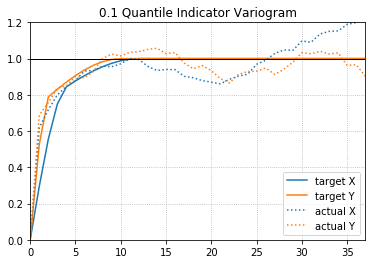

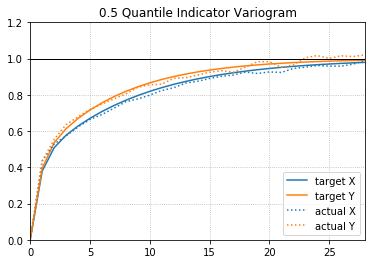

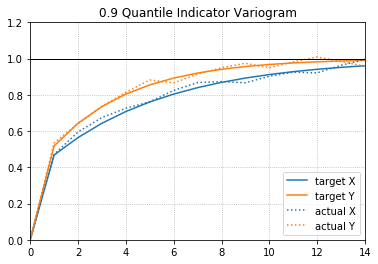

In [24]:
xscale = [0.66, 0.5, 0.25]
for j, q in enumerate(quantiles):
    fig, ax = plt.subplots()
    igx, igy = griddedgam(ireference[:, j].reshape(ny, nx))
    ax.plot(ivarios[q][0], c="C0", label="target X")
    ax.plot(ivarios[q][1], c="C1", label="target Y")
    ax.plot(igx / ivars[j], c="C0", ls=":", label="actual X")
    ax.plot(igy / ivars[j], c="C1", ls=":", label="actual Y")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, nx * xscale[j])
    ax.legend()

In [25]:
# indicator transform of comps
def indicator_transform_df(df, var, threhsolds):
    """Transform var to indicators based on thresholds"""
    ind_cols = [f"{q} Indicator" for q in thresholds.keys()]
    df = df.reindex(columns=df.columns.tolist() + ind_cols)
    df[ind_cols] = 0
    for q, t in thresholds.items():
        df.loc[df[var] <= t, f"{q} Indicator"] = 1
    df = df.astype({col: int for col in ind_cols})
    return df


comps = indicator_transform_df(comps, var, thresholds)
comps.head()

,dhid,X,Y,var,0.1 Indicator,0.5 Indicator,0.9 Indicator
0,0,5.0,56.0,0.274784,0,0,1
1,0,5.0,55.0,0.062787,0,0,1
2,0,5.0,54.0,0.030778,0,0,1
3,0,5.0,53.0,-1.125156,0,1,1
4,0,5.0,52.0,-0.158525,0,1,1


# Runs

In [26]:
def binary_runs(x, runs_above):
    """Calcualte runs and cumulative runs in binary array x"""
    runs_data = {}
    x = np.asarray(x)
    first_run = x[0]  # 1 or 0
    runstart = np.nonzero(np.diff(np.r_[[-np.inf], x, [np.inf]]))[0]
    runs = np.diff(runstart)
    runs = _check_runs_above(first_run, runs, runs_above)
    cum_runs = []
    for run in runs:
        for i in range(run):
            sub_run_length = run - i
            num_sub_runs = i + 1
            cum_runs.append([*[sub_run_length] * num_sub_runs])

    runs_data["runs"] = runs
    runs_data["cum_runs"] = np.array([a for b in cum_runs for a in b])
    runs_data["run_idxs"] = runstart
    runs_data["n_runs"] = len(runs)

    try:  # catch situation where all runs are below/above?
        runs_data["cum_runs_freqs"] = np.bincount(runs_data["cum_runs"])[1:]
        runs_data["runs_freqs"] = np.bincount(runs)[1:]
    except:
        runs_data["cum_runs_freqs"] = np.array([])
        runs_data["runs_freqs"] = np.array([])

    return runs_data


def _check_runs_above(first_run, runs, runs_above=True):
    if runs_above:
        if first_run:
            runs = runs[1::2]
        else:
            runs = runs[0::2]
        return runs
    else:
        return runs

## CDF

In [27]:
# runs_above = True
# global_runs = {q: [] for q in thresholds}

# # merge runs from each drillhole into a global histogram
# for q, t in thresholds.items():
#     temp_runs = []
#     for uid in comps[dhid].unique():
#         dh = comps.loc[comps[dhid] == uid, f"{q} Indicator"].copy()
#         temp_runs.append(
#             binary_runs(dh.values, runs_above)["cum_runs"].tolist()
#         )
#     global_runs[q] = np.asarray([a for b in temp_runs for a in b])

In [28]:
# @jit(nopython=True)
# def init_ecdf(xvals, wts, nhist):
#     """initilize emperical cdf from input array"""
#     wts = np.ones(len(xvals)) / len(xvals)

#     # calculate ecdf from xvals
#     pvals = np.array([i / (nhist + 1) for i in range(1, nhist + 1)])
#     order = xvals.argsort()
#     cdf_x = xvals[order]
#     cdf_y = np.cumsum(wts[order])
#     cdf_y = cdf_y - cdf_y[0] / 2
#     zvals = np.interp(pvals, cdf_y, cdf_x)

#     # calculate actual fraction less than each pval
#     frac = np.zeros(nhist)
#     for x in cdf_x:
#         for i in range(nhist):
#             if x < zvals[i]:
#                 frac[i] += 1
#     frac /= len(xvals)

#     return zvals, frac

In [29]:
# nhist = 200
# wts = None
# target_runs = {}
# for j, q in enumerate(thresholds):
#     target_runs[q], _ = init_ecdf(global_runs[q], wts=wts, nhist=nhist)

In [30]:
# for j, q in enumerate(thresholds):
#     fig, ax = plt.subplots()
#     cruns = np.sort(target_runs[q])
#     yy = np.arange(len(cruns)) / (len(cruns) + 1)
#     _ = ax.plot(cruns, yy)

## Histogram

In [31]:
runs_above = True
global_runs = {q: [] for q in thresholds}
maxrun = 15

# merge runs from each drillhole into a global histogram
for q, t in thresholds.items():
    temp_runs = np.zeros(maxrun)
    for uid in comps[dhid].unique():
        dh = comps.loc[comps[dhid] == uid, f"{q} Indicator"].copy()
        run_freqs = binary_runs(dh.values, runs_above)["cum_runs_freqs"][
            :maxrun
        ]
        temp_runs += np.pad(run_freqs, (0, maxrun - len(run_freqs)))
    global_runs[q] = temp_runs

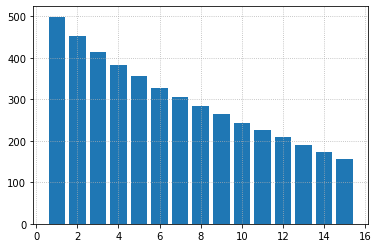

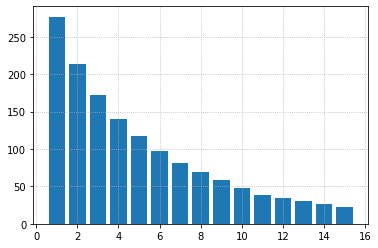

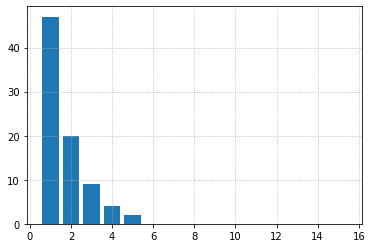

In [32]:
for q in thresholds:
    fig, ax = plt.subplots()
    _ = ax.bar(np.arange(maxrun) + 1, global_runs[q])

# n-Point Connectivity

In [33]:
# # @jit(nopython=True)
# def n_pt_conn(X, nstep):
#     """Global n-point connectivity fucntion of binary matrix X
#     X.shape = (len(dh), ndh)
#     """
#     X = np.asarray(X)
#     nx = X.shape[0]
#     ndh = X.shape[1]
#     phi_n = np.zeros(nstep, dtype=np.float64)
#     for n in range(1, nstep + 1):
#         prod = []
#         for k in range(ndh):
#             x = X[:, k]
#             for i in range(nx - n + 1):
#                 idxs = [i] + [j + i for j in range(n)]
#                 a = [x[int(idx)] for idx in idxs]
#                 p = 1
#                 for i in a:
#                     p *= i
#                 prod.append(p)
#         phi_n[n - 1] = np.mean(np.array(prod, dtype=np.float64))
#     return np.asarray(phi_n)

@jit(nopython=True)
def n_pt_conn(X, nstep):
    """Global n-point connectivity fucntion of binary matrix X
    X.shape = (len(dh), ndh)
    """
    X = np.asarray(X)
    nx = X.shape[0]
    ndh = X.shape[1]
    phi_n = np.zeros(nstep, dtype=np.float64)
    
    for n in range(1, nstep + 1):
        
        prod = np.zeros((nx-(n-1))*ndh, dtype=np.float64)
        temp_idx = np.array([0] + [j for j in range(n)])
        
        for k in range(ndh):
            
            x = X[:, k]
            
            for i in range(nx - n + 1):
                
                idxs = temp_idx + i
                arr = x[idxs]
                
                p = 1
                for a in arr:
                    p *= a
                
                ii = i + (nx-(n-1)) * k
                
                prod[ii] = p

        phi_n[n - 1] = np.mean(prod)

    return phi_n

In [34]:
np.append(np.array([0]), np.arange(5))

array([0, 0, 1, 2, 3, 4])

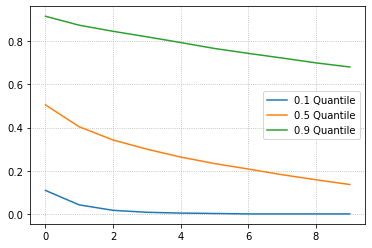

In [35]:
nstep = 10
target_npoint = {}

for j, q in enumerate(thresholds):

    X = np.zeros((nx, ndh))
    for i, uid in enumerate(comps[dhid].unique()):
        X[:, i] = comps.loc[comps[dhid] == uid, f"{q} Indicator"].values

    target_npoint[q] = n_pt_conn(X, nstep=nstep)
    plt.plot(target_npoint[q], label=f"{q} Quantile")
    plt.legend()

# nstep = 10
# target_npoint = {}

# for j, q in enumerate(thresholds):

#     X = np.zeros((nx, 1))
#     X[:, 0] = comps.loc[comps[dhid] == 0, f"{q} Indicator"].values
#     target_npoint[q] = n_pt_conn(X, nstep=nstep)
#     if j ==1:
#         break
#     plt.plot(target_npoint[q], label=f"{q} Quantile")
#     plt.legend()

In [36]:
# for j, q in enumerate(thresholds):
    
#     X = np.zeros((nx, ndh))
#     for i, uid in enumerate(comps[dhid].unique()):
#         X[:, i] = comps.loc[comps[dhid] == uid, f"{q} Indicator"].values
        
#     X = np.asarray(X)
#     nx = X.shape[0]
#     ndh = X.shape[1]
#     phi_n = np.zeros(nstep, dtype=np.float64)

#     for n in range(1, nstep + 1):

#         prod = np.zeros((nx-(n-1))*ndh, dtype=np.float64)

#         temp_idx = np.array([0] + [*range(n)])
#     #     print(temp_idx)

#         for k in range(ndh):

#             x = X[:, k]

#             for i in range(nx - n + 1):


#     #             idxs = [i] + [j + i for j in range(n)]
#                 idxs = temp_idx + i

#     #             print(idxs)
#     #                 break

#                 arr = x[idxs]

#                 p = 1
#                 for a in arr:
#                     p *= a

#                 ii = i + (nx-(n-1)) * k

#                 prod[ii] = p

#     #             print(len(prod), k)

#     #         print("final prod length:", len(prod))
#     #         print("\n")

#     #         phi_n[n - 1] = np.mean(np.array(prod, dtype=np.float64))
#         phi_n[n - 1] = np.mean(prod)
        
#     plt.plot(phi_n, label=f"{q} Quantile")
#     plt.legend()

In [37]:
# %prun n_pt_conn(X, nstep=56)

In [38]:
%timeit n_pt_conn(X, nstep=56)

3.4 ms ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
# %timeit n_pt_conn2(X, nstep=56)

# Factor Variogram Models

In [40]:
sph_fact = 5
exp_fact = 5
gau_fact = 5
n_fact = sph_fact + exp_fact + gau_fact

max_range = int(nx * 0.66)
min_range = int(nx * 0.10)

sph_ranges_x = np.linspace(min_range, max_range, num=sph_fact, endpoint=False)
exp_ranges_x = np.linspace(min_range, max_range, num=exp_fact, endpoint=False)
gau_ranges_x = np.linspace(min_range, max_range, num=gau_fact, endpoint=False)

sph_ranges_y = np.linspace(
    min_range, max_range / 2, num=sph_fact, endpoint=False
)
exp_ranges_y = np.linspace(
    min_range, max_range / 2, num=exp_fact, endpoint=False
)
gau_ranges_y = np.linspace(
    min_range, max_range / 2, num=gau_fact, endpoint=False
)

sph_struct = [1] * sph_fact
exp_struct = [2] * exp_fact
gau_struct = [3] * gau_fact

ranges_x = np.concatenate((sph_ranges_x, exp_ranges_x, gau_ranges_x))
ranges_y = np.concatenate((sph_ranges_y, exp_ranges_y, gau_ranges_y))
structs = np.concatenate((sph_struct, exp_struct, gau_struct))

In [41]:
structs

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [42]:
ranges_x

array([ 5. , 11.2, 17.4, 23.6, 29.8,  5. , 11.2, 17.4, 23.6, 29.8,  5. ,
       11.2, 17.4, 23.6, 29.8])

In [43]:
ranges_y

array([ 5. ,  7.6, 10.2, 12.8, 15.4,  5. ,  7.6, 10.2, 12.8, 15.4,  5. ,
        7.6, 10.2, 12.8, 15.4])

# Factor Simulation
- Each initial factor is simulated with a different random number seed and a completely different variogram
- Each initial factor has a single pure structure that reflects something with unique spatial correlation that could translate to something combined with other factors

## Grid

In [44]:
Ysim = np.zeros([nxy, n_fact + 1])
Ysim[:, 0] = rng.normal(size=nxy)  # nugget
C = []
for i, (st, rx, ry) in enumerate(zip(structs, ranges_x, ranges_y)):
    if st < 3:
        c = sim.pairwisecova_2D(
            P, ranges_x=[rx], ranges_y=[ry], vtypes=[st], c0=0.0, cc=[1.0]
        )
    else:  # small nugget to avoid singular matrix with Gaussian model
        c = sim.pairwisecova_2D(
            P, ranges_x=[rx], ranges_y=[ry], vtypes=[st], c0=0.001, cc=[0.999]
        )
    Ysim[:, i + 1] = sim.lusim(c, nr=1, seed=78451 + i * 1000)
    C.append(c)

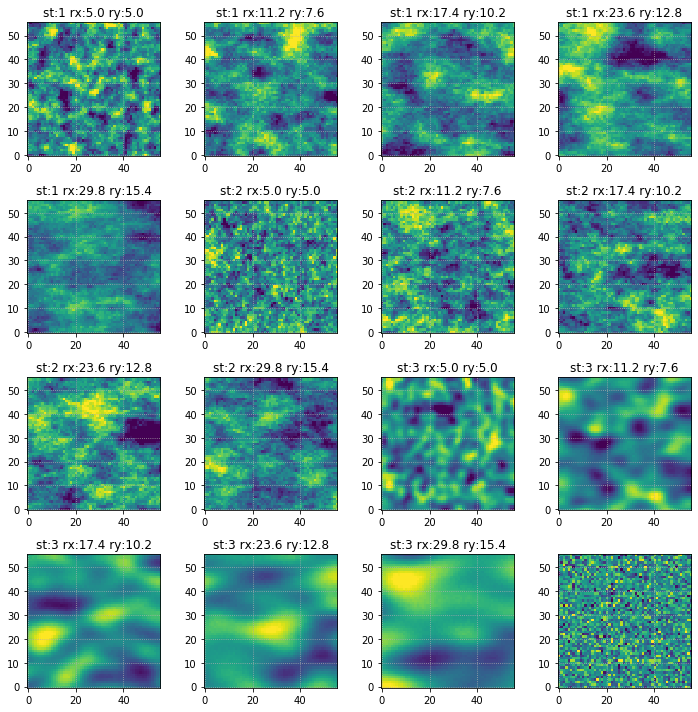

In [45]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (ax, st, rx, ry) in enumerate(
    zip(axes.flatten(), structs, ranges_x, ranges_y),
):
    im = ax.imshow(
        Ysim[:, i + 1].reshape(ny, nx), origin="lower", vmin=-2.5, vmax=2.5
    )
    #     plt.colorbar(im, ax=ax)
    ax.set_title(f"st:{st} rx:{rx} ry:{ry}")
axes[-1, -1].imshow(
    Ysim[:, 0].reshape(ny, nx), origin="lower", vmin=-2.5, vmax=2.5
)
fig.tight_layout()

## Data Locations

In [46]:
coords = comps[["X", "Y"]].values
nxyd = len(coords)
Ysimd = np.zeros([nxyd, n_fact + 1])
Ysimd[:, 0] = rng.normal(size=nxyd)  # nugget
C = []
for i, (st, rx, ry) in enumerate(zip(structs, ranges_x, ranges_y)):
    if st < 3:
        c = sim.pairwisecova_2D(
            coords, ranges_x=[rx], ranges_y=[ry], vtypes=[st], c0=0.0, cc=[1.0]
        )
    else:  # small nugget to avoid singular matrix with Gaussian model
        c = sim.pairwisecova_2D(
            coords,
            ranges_x=[rx],
            ranges_y=[ry],
            vtypes=[st],
            c0=0.001,
            cc=[0.999],
        )
    Ysimd[:, i + 1] = sim.lusim(c, nr=1, seed=78451 + i * 1000)
    C.append(c)

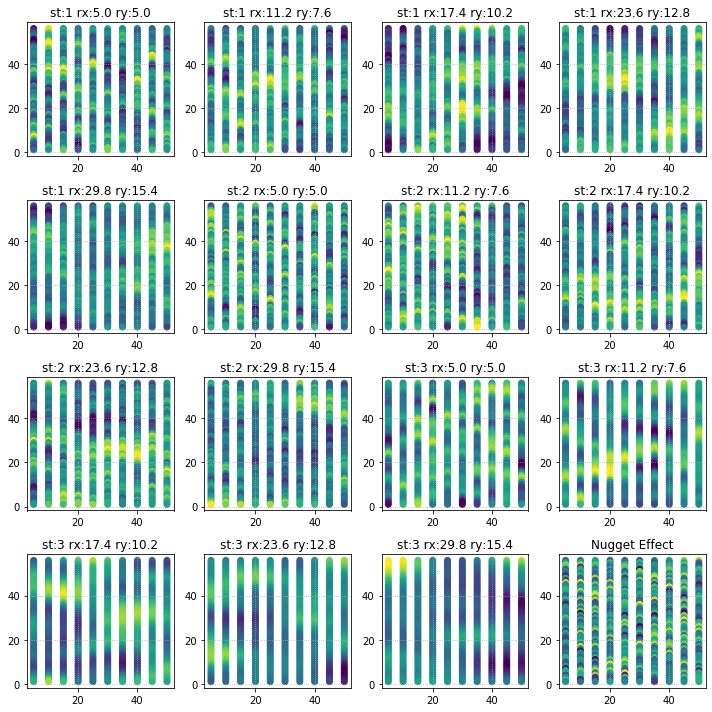

In [47]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, (ax, st, rx, ry) in enumerate(
    zip(axes.flatten(), structs, ranges_x, ranges_y),
):
    im = ax.scatter(
        coords[:, 0], coords[:, 1], c=Ysimd[:, i + 1], vmin=-2.5, vmax=2.5
    )
    #     plt.colorbar(im, ax=ax)
    ax.set_title(f"st:{st} rx:{rx} ry:{ry}")
axes[-1, -1].scatter(
    coords[:, 0], coords[:, 1], c=Ysimd[:, 0], vmin=-2.5, vmax=2.5
)
axes[-1, -1].set_title("Nugget Effect")
fig.tight_layout()

# Network LMR

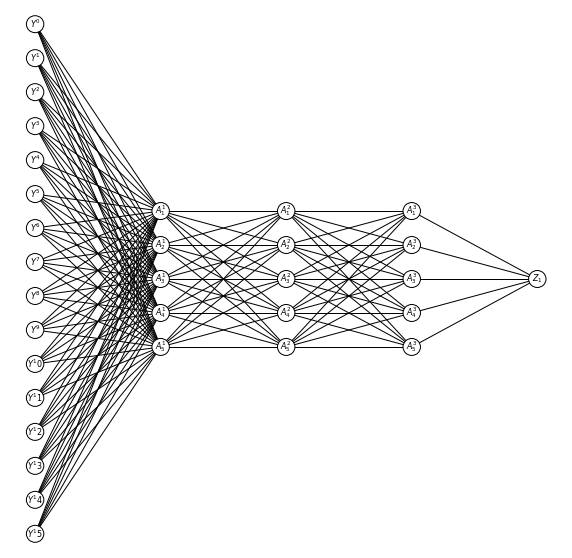

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")
layer_dims = [n_fact + 1, 5, 5, 5, 1]
# layer_dims = [n_fact + 1, 1]
draw_neural_net(ax, 0.05, 0.95, 0.0, 1.0, layer_dims, "Y", "A", "Z", 8)

In [49]:
parameters = nn.intitialize_layer_params(layer_dims, 69420)

In [50]:
connections = []
for k, v in parameters.items():
    if "W" in k:
        connections.append(v.shape[0] * v.shape[1])
    print(k, "shape:", v.shape)
tconn = np.sum(connections)
print("Total connections:", tconn)

W1 shape: (5, 16)
b1 shape: (5, 1)
W2 shape: (5, 5)
b2 shape: (5, 1)
W3 shape: (5, 5)
b3 shape: (5, 1)
W4 shape: (1, 5)
b4 shape: (1, 1)
Total connections: 135


In [51]:
AL = nn.linear_forward(Ysimd, parameters, nn.relu)

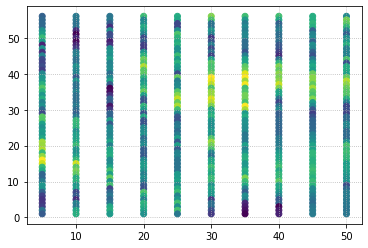

In [52]:
plt.scatter(coords[:, 0], coords[:, 1], c=AL, vmin=-2.5, vmax=2.5)

# Objective Components

## Utils

In [53]:
def vector_to_matrices(parameters, connections, x):
    """reshape 1D vector into appropriate matrices"""
    L = len(parameters) // 2
    num_wts = np.cumsum([0] + connections)
    for ell in range(1, L + 1):
        shape = parameters["W" + str(ell)].shape
        parameters["W" + str(ell)] = x[num_wts[ell - 1] : num_wts[ell]].reshape(
            shape
        )
    return parameters

## Variograms

In [54]:
def generate_lag_dict(coords, values, nlags, azm, atol, maxlag):
    """generate dictionary of pair indices for each variogram lag"""
    from scipy.spatial.distance import squareform
    from skgstat import DirectionalVariogram

    lag_dict = {}
    DV = DirectionalVariogram(
        coords,
        values,
        azimuth=azm,
        tolerance=atol,
        n_lags=nlags,
        maxlag=maxlag,
    )
    tril = np.tril_indices(len(coords), k=0)
    gmat = squareform(DV.lag_groups())
    gmat[tril] = -1

    for i in range(nlags):
        lag_dict[i] = np.argwhere(gmat == i)

    return lag_dict, DV.bins.tolist()


xnlags = 7
ynlags = 20
xazm = 0  # horizontal
yazm = 90  # vertical
atol = 25
maxlag = int(nx * 0.66)

xlag_dict, xbins = generate_lag_dict(
    coords, comps[var].values, xnlags, xazm, atol, maxlag
)
ylag_dict, ybins = generate_lag_dict(
    coords, comps[var].values, ynlags, yazm, atol, maxlag
)

In [55]:
xlag_dict[0].shape

(1494, 2)

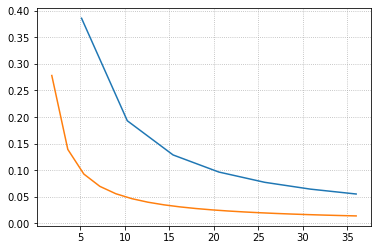

In [58]:
def inv_dist(bins, power):
    if not bins:
        return
    wts = 1 / np.array(bins) ** power
    return wts / np.sum(wts)


plt.plot(xbins, inv_dist(xbins, 1))
plt.plot(ybins, inv_dist(ybins, 1))

In [59]:
def update_variogram(values, lag_dict):
    """updated current experimental variogram with `values`
    TODO: account for lags with no pairs
    """
    if not lag_dict:
        return
    nlags = len(lag_dict)
    expvario = np.full(nlags, np.nan)
    for n in range(nlags):
        tail = values[lag_dict[n][:, 0]]
        head = values[lag_dict[n][:, 1]]
        if len(tail) == 0 or len(head) == 0:
            #             print(f"No pairs in lag {n}!")
            continue
        expvario[n] = 1 / (2 * len(tail)) * np.sum((tail - head) ** 2)
    # set missing values to sill
    expvario[np.isnan(expvario)] = np.var(values)
    return expvario


xvario = update_variogram(AL, xlag_dict)
yvario = update_variogram(AL, ylag_dict)

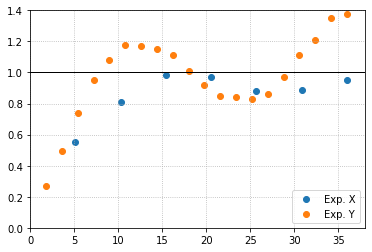

In [60]:
fig, ax = plt.subplots()
ax.scatter(xbins, xvario, label="Exp. X")
ax.scatter(ybins, yvario, label="Exp. Y")
ax.set_ylim(0, 1.4)
ax.set_xlim(0)
ax.axhline(1.0, c="k", lw=1)
ax.legend(loc=4)

In [61]:
def get_vario_model_points(model_pts, lags):
    """get variogram model values at corresponding experimental lag dists"""
    xvals = np.arange(len(model_pts))
    return np.interp(lags, xvals, model_pts)


def expvario_loss(exp_pts, model_pts, lags, lag_wts, sill):
    """squared error between experimental points and variogram model"""
    if not np.array(exp_pts).any():
        return 0.0
    exp_pts /= sill
    model_at_lags = get_vario_model_points(model_pts, lags)
    return np.sum(((exp_pts - model_at_lags) ** 2) * lag_wts)

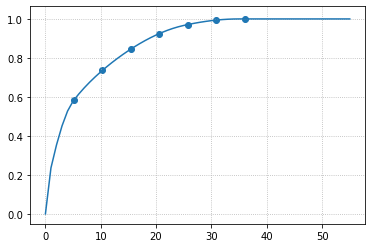

In [62]:
plt.scatter(xbins, get_vario_model_points(target_x, xbins))
plt.plot(target_x)

In [63]:
#
# variograms
#


def objective_vario(AL, targets, lag_dicts, lags, scale):
    """continuous variogram objective function"""
    tx, ty, *tz = targets
    xlag, ylag, *zlag = lag_dicts
    lx, ly, *lz = lags
    xvario = update_variogram(AL, xlag)
    yvario = update_variogram(AL, ylag)
    zvario = update_variogram(AL, zlag)
    xlag_wts = inv_dist(lx, 1.0)
    ylag_wts = inv_dist(ly, 1.0)
    zlag_wts = inv_dist(lz, 1.0)
    sill = np.var(AL)
    objv = 0.0
    objv += expvario_loss(xvario, tx, lx, xlag_wts, sill)
    objv += expvario_loss(yvario, ty, ly, ylag_wts, sill)
    objv += expvario_loss(zvario, tz, lz, zlag_wts, sill)
    return objv * scale


def init_vario(
    Y, targets, lag_dicts, lags, connections, parameters, bounds, afunc, seed,
):
    """initialize continuous variogram objective function"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_vario(AL, targets, lag_dicts, lags, scale=1.0)
    return objv

In [64]:
objective_vario(
    AL, [target_x, target_y], [xlag_dict, ylag_dict], [xbins, ybins], scale=1.0
)

0.03531778658274881

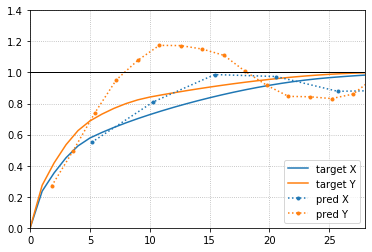

In [65]:
fig, ax = plt.subplots()
gx = update_variogram(AL, xlag_dict)
gy = update_variogram(AL, ylag_dict)
ax.plot(target_x, c="C0", label="target X")
ax.plot(target_y, c="C1", label="target Y")
ax.plot(xbins, gx, c="C0", ls=":", marker=".", label="pred X")
ax.plot(ybins, gy, c="C1", ls=":", marker=".", label="pred Y")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.4)
ax.set_xlim(0, nx * 0.5)
ax.legend()

In [66]:
#
# indicator variograms
#


def objective_ivario(AL, targets, lag_dicts, lags, thresholds, scale):
    """continuous variogram objective function"""
    xlag, ylag, *zlag = lag_dicts
    lx, ly, *lz = lags
    xlag_wts = inv_dist(lx, 1.0)
    ylag_wts = inv_dist(ly, 1.0)
    zlag_wts = inv_dist(lz, 1.0)
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    nq = len(thresholds)
    objv = 0.0
    for j, q in enumerate(thresholds):
        tx, ty, *tz = targets[q]
        sill = ivars[j]
        xivario = update_variogram(AL_i[:, j], xlag)
        yivario = update_variogram(AL_i[:, j], ylag)
        zivario = update_variogram(AL_i[:, j], zlag)
        objv += expvario_loss(xivario, tx, lx, xlag_wts, sill)
        objv += expvario_loss(yivario, ty, ly, ylag_wts, sill)
        objv += expvario_loss(zivario, tz, lz, zlag_wts, sill)
    return objv * scale


def init_ivario(
    Y, targets, lag_dicts, lags, connections, parameters, bounds, afunc, seed,
):
    """initialize continuous variogram objective function"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_ivario(AL, targets, lag_dicts, lags, thresholds, scale=1.0)
    return objv

In [67]:
objective_ivario(
    AL, ivarios, [xlag_dict, ylag_dict], [xbins, ybins], thresholds, scale=1.0
)

0.1023672472080321

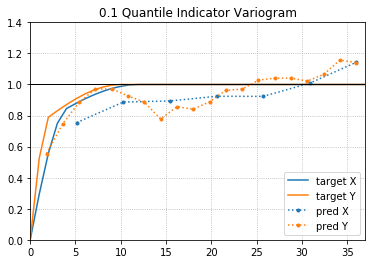

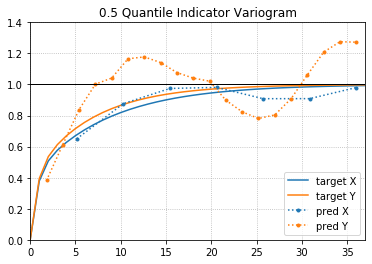

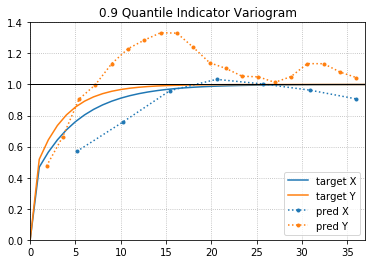

In [68]:
AL_i, ivars = indicator_transform(AL, thresholds.values())
for j, q in enumerate(quantiles):
    fig, ax = plt.subplots()
    igx = update_variogram(AL_i[:, j], xlag_dict) / ivars[j]
    igy = update_variogram(AL_i[:, j], ylag_dict) / ivars[j]
    ax.plot(ivarios[q][0], c="C0", label="target X")
    ax.plot(ivarios[q][1], c="C1", label="target Y")
    ax.plot(xbins, igx, c="C0", ls=":", marker=".", label="pred X")
    ax.plot(ybins, igy, c="C1", ls=":", marker=".", label="pred Y")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.4)
    ax.set_xlim(0, nx * 0.66)
    ax.legend()

## Runs

### CDF

In [69]:
# #
# # Runs
# #


# def objective_histogram(arr, target, wts, nhist, scale):
#     """histogram objective function component"""
#     zvals, _ = init_ecdf(arr, wts, nhist)
#     objv = 0.0
#     objv += np.sum((zvals - target) ** 2) / len(zvals)
#     return objv * scale


# def objective_runs(AL, target, thresholds, runs_above, wts, nhist, scale):
#     AL_i, ivars = indicator_transform(AL, thresholds.values())
#     objv = 0.0
#     for j, q in enumerate(thresholds):
#         runs = binary_runs(AL_i[:, j], runs_above)["cum_runs"]
#         objv += objective_histogram(runs, target[q], wts, nhist, scale)
#     return objv


# def init_runs(
#     Y,
#     target,
#     nhist,
#     thresholds,
#     runs_above,
#     connections,
#     parameters,
#     bounds,
#     afunc,
#     seed,
# ):
#     """initialize runs objective"""
#     rng = np.random.default_rng(seed)
#     x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
#     parameters = vector_to_matrices(parameters, connections, x)
#     AL = nn.linear_forward(Y, parameters, afunc)
#     objv = objective_runs(
#         AL, target, thresholds, runs_above, wts=None, nhist=nhist, scale=1.0
#     )
#     return objv

In [70]:
# objective_runs(
#     AL, target_runs, thresholds, runs_above, wts=None, nhist=nhist, scale=1.0
# )

In [71]:
# for j, q in enumerate(thresholds):
#     fig, ax = plt.subplots()
#     target_cruns = np.sort(target_runs[q])
#     cruns = binary_runs(AL_i[:, j], runs_above=True)["cum_runs"]
#     cruns, _ = init_ecdf(cruns, wts=None, nhist=nhist)
#     pvals = [i / (nhist + 1) for i in range(1, nhist + 1)]
#     ax.plot(target_cruns, pvals, label="target CDF")
#     ax.plot(cruns, pvals, ls=":", c="C0", label="pred CDF")
#     ax.legend(loc=4)

### Histogram

In [72]:
def objective_histogram(hist, target, scale):
    """relative mse between histogram bins"""
    #     objv = np.sum(((hist - target) / target) ** 2) / len(hist)
    objv = np.sum(((hist - target)) ** 2) / len(hist)
    return objv * scale


def objective_runs(
    AL, target, thresholds, runs_above, maxrun, ncomps, ndh, scale
):
    """cumulative run frequency objective fucntion"""
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    objv = 0.0
    for j, q in enumerate(thresholds):
        X = AL_i[:, j].reshape(ncomps, ndh, order="F")
        temp_runs = np.zeros(maxrun)
        for n in range(ndh):
            run_freqs = binary_runs(X[:, n], runs_above)["cum_runs_freqs"][
                :maxrun
            ]
            temp_runs += np.pad(run_freqs, (0, maxrun - len(run_freqs)))
        objv += objective_histogram(temp_runs, target[q], scale)
    return objv


def init_runs(
    Y,
    target,
    maxrun,
    ncomps,
    ndh,
    thresholds,
    runs_above,
    connections,
    parameters,
    bounds,
    afunc,
    seed,
):
    """initialize runs objective"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_runs(
        AL, target, thresholds, runs_above, maxrun, ncomps, ndh, scale=1.0
    )
    return objv

In [73]:
objective_runs(
    AL, global_runs, thresholds, runs_above, maxrun, ncomps, ndh, scale=1.0
)

1801.6

## n-point connectivity

In [74]:
#
# n-point connectivity
#


# def objective_npoint(AL, target, thresholds, nstep, ncomps, ndh, scale):
#     """n-point connectivity objective fucntion"""
#     AL_i, ivars = indicator_transform(AL, thresholds.values())
#     objv = 0.0
#     for j, q in enumerate(thresholds):
#         npoint = n_pt_conn(AL_i[:, j].reshape(ncomps, ndh, order="F"), nstep)
#         objv += np.sum((npoint - target[q]) ** 2) / len(npoint)
#     return objv * scale


# def init_npoint(
#     Y, target, thresholds, nstep, connections, parameters, bounds, afunc, seed
# ):
#     """initialize n-point connectivity objective"""
#     rng = np.random.default_rng(seed)
#     x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
#     parameters = vector_to_matrices(parameters, connections, x)
#     AL = nn.linear_forward(Y, parameters, afunc)
#     objv = objective_npoint(
#         AL, target, thresholds, nstep, ncomps, ndh, scale=1.0
#     )
#     return objv


def objective_npoint(AL, target, thresholds, nstep, ncomps, ndh, scale):
    """n-point connectivity objective fucntion"""
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    objv = 0.0
    for j, q in enumerate(thresholds):
        npoint = n_pt_conn(AL_i[:, j].reshape(ncomps, ndh, order="F"), nstep)
        objv += objective_histogram(npoint, target[q], scale)
    return objv


def init_npoint(
    Y, target, thresholds, nstep, connections, parameters, bounds, afunc, seed
):
    """initialize n-point connectivity objective"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_npoint(
        AL, target, thresholds, nstep, ncomps, ndh, scale=1.0
    )
    return objv

In [75]:
objective_npoint(AL, target_npoint, thresholds, nstep, ncomps, ndh, scale=1.0)

0.0059064055971046565

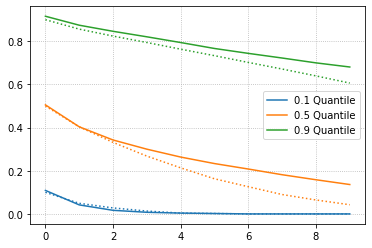

In [76]:
for j, q in enumerate(thresholds):
    npoint = n_pt_conn(AL_i[:, j].reshape(ncomps, ndh, order="F"), nstep=nstep)
    plt.plot(target_npoint[q], c=f"C{j}", label=f"{q} Quantile")
    plt.plot(npoint, c=f"C{j}", ls=":")
    plt.legend()

# Objective Scaling

In [77]:
def objective_scaling(
    Y,
    connections,
    parameters,
    bounds,
    lag_dicts,
    lags,
    thresholds,
    runs_above,
    maxrun,
    nstep,
    ncomps,
    ndh,
    afunc,
    maxpert,
    seed,
    vario=True,
    vario_target=None,
    ivario=True,
    ivario_target=None,
    runs=True,
    runs_target=None,
    npoint=True,
    npoint_target=None,
):
    rng = np.random.default_rng(seed)

    objinit = np.zeros(4)
    objscale = np.ones(4)
    objdelta = np.zeros(4)

    # initalize objective values
    if vario:
        objinit[0] = init_vario(
            Y,
            vario_target,
            lag_dicts,
            lags,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if ivario:
        objinit[1] = init_ivario(
            Y,
            ivario_target,
            lag_dicts,
            lags,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if runs:
        objinit[2] = init_runs(
            Y,
            runs_target,
            maxrun,
            ncomps,
            ndh,
            thresholds,
            runs_above,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if npoint:
        objinit[3] = init_npoint(
            Y,
            npoint_target,
            thresholds,
            nstep,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )

    for m in range(maxpert):

        # draw random parameter vector
        x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))

        # reshape x into matrices
        parameters = vector_to_matrices(parameters, connections, x)

        # caluclate the forward pass
        AL = nn.linear_forward(Y, parameters, afunc)

        # approximate objective contributions
        if vario:
            temp_obj_vario = objective_vario(
                AL, vario_target, lag_dicts, lags, scale=objscale[0]
            )
            if temp_obj_vario < 0.0:
                temp_obj_vario = objinit[0]
            objdelta[0] += np.abs(objinit[0] - temp_obj_vario)

        if ivario:
            temp_obj_ivario = objective_ivario(
                AL,
                ivario_target,
                lag_dicts,
                lags,
                thresholds,
                scale=objscale[1],
            )
            if temp_obj_ivario < 0.0:
                temp_obj_ivario = objinit[1]
            objdelta[1] += np.abs(objinit[1] - temp_obj_ivario)

        if runs:
            temp_obj_runs = objective_runs(
                AL,
                runs_target,
                thresholds,
                runs_above,
                maxrun,
                ncomps,
                ndh,
                scale=objscale[2],
            )
            if temp_obj_runs < 0.0:
                temp_obj_runs = objinit[2]
            objdelta[2] += np.abs(objinit[2] - temp_obj_runs)

        if npoint:
            temp_obj_npt = objective_npoint(
                AL,
                npoint_target,
                thresholds,
                nstep,
                ncomps,
                ndh,
                scale=objscale[3],
            )
            if temp_obj_npt < 0.0:
                temp_obj_npt = objinit[3]
            objdelta[3] += np.abs(objinit[3] - temp_obj_npt)

    # scale objective components
    if vario:
        objscale[0] = maxpert / objdelta[0]
    if ivario:
        objscale[1] = maxpert / objdelta[1]
    if runs:
        objscale[2] = maxpert / objdelta[2]
    if npoint:
        objscale[3] = maxpert / objdelta[3]

    # rescale factor
    rescale = 0.0
    for objv, scl in zip(objinit, objscale):
        rescale += scl * objv
    rescale = 1 / max(rescale, 1e-10)
    objscale *= rescale

    return objscale

In [78]:
bounds = (0.05, 0.95)
afunc = nn.tanh
maxpert = 1000
seed = 1044

objscale = objective_scaling(
    Ysimd,
    connections,
    parameters,
    bounds,
    [xlag_dict, ylag_dict],
    [xbins, ybins],
    thresholds,
    runs_above,
    #     wts,
    #     nhist,
    maxrun,
    nstep,
    ncomps,
    ndh,
    afunc,
    maxpert,
    seed,
    vario=True,
    vario_target=[target_x, target_y],
    ivario=True,
    ivario_target=ivarios,
    runs=True,
    runs_target=global_runs,
    npoint=True,
    npoint_target=target_npoint,
)

targets = [
    "Continous Variogram",
    "Indicator Variograms",
    "Cumulative Runs",
    "n-Point Connectivity",
]
for name, oscl in zip(targets, objscale):
    print(f"{name} scale factor: {oscl}\n")

Continous Variogram scale factor: 5.695460124796915

Indicator Variograms scale factor: 2.848113004870317

Cumulative Runs scale factor: 3.1555657050386774e-05

n-Point Connectivity scale factor: 24.23768162642393



# Objective Function

In [79]:
def network_lmr_objective(x, *args):
    """objective function for network lmr"""

    # caluclate the forward pass
    params = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, params, afunc)

    # initialize objective value
    objv = 0.0

    # continuous variogram
    if vario:
        objv += objective_vario(AL, target_vario, lag_dicts, lags, objscale[0])

    # indicator variogram
    if ivario:
        objv += objective_ivario(
            AL, target_ivario, lag_dicts, lags, thresholds, objscale[1]
        )

    # cumulative runs
    if runs:
        objv += objective_runs(
            AL,
            target_runs,
            thresholds,
            runs_above,
            maxrun,
            ncomps,
            ndh,
            objscale[2],
        )

    # npoint connectivity runs
    if npoint:
        objv += objective_npoint(
            AL, target_npoint, thresholds, nstep, ncomps, ndh, objscale[3]
        )

    return objv

In [81]:
# lag_dicts = [xlag_dict, ylag_dict, {}]
# lags = [xbins, ybins, []]
# target_vario = [target_x, target_y, []]
# target_ivario = ivarios
# target_runs = global_runs
# Y = Ysimd.copy()

# vario = True
# ivario = True
# runs = True
# npoint = True

# args = (
#     parameters,
#     connections,
#     Y,
#     target_vario,
#     target_ivario,
#     target_runs,
#     target_npoint,
#     #     wts,
#     #     nhist,
#     maxrun,
#     nstep,
#     ncomps,
#     ndh,
#     runs_above,
#     thresholds,
#     afunc,
#     objscale,
#     vario,
#     ivario,
#     runs,
#     npoint,
# )
# results = list(
#     opt.de(
#         network_lmr_objective,
#         args,
#         bounds=[bounds] * tconn,
#         popsize=15,
#         mut=(0.5, 1),
#         crossp=0.9,
#         its=100,
#         seed=21,
#         K=25,
#         g=1e-5,
#     )
# )
# objective = []
# for result in results:
#     objective.append(result[-1])
# plt.plot(objective)

In [ ]:
# %prun list(opt.de(network_lmr_objective, args, bounds=[bounds] * tconn,popsize=15, mut=(0.5, 1), crossp=0.9, its=100, seed=21, K=25, g=1e-5))

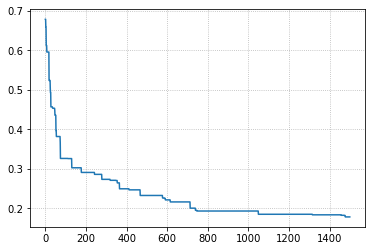

In [85]:
lag_dicts = [xlag_dict, ylag_dict, {}]
lags = [xbins, ybins, []]
target_vario = [target_x, target_y, []]
target_ivario = ivarios
target_runs = global_runs
Y = Ysimd.copy()

vario = True
ivario = True
runs = True
npoint = True

# args = (
#     parameters,
#     connections,
#     target_vario,
#     target_ivario,
#     target_runs,
#     target_npoint,
#     lag_dicts,
#     lags,
#     maxrun,
#     nstep,
#     ncomps,
#     ndh,
#     runs_above,
#     thresholds,
#     afunc,
#     objscale,
#     vario,
#     ivario,
#     runs,
#     npoint,
# )

args = (
    parameters,
    connections,
    target_vario,
    target_ivario,
    target_runs,
    target_npoint,
    lag_dicts,
    lags,
    maxrun,
    nstep,
    dhids,
    dh_lens,
    runs_above,
    thresholds,
    afunc,
    objscale,
    vario,
    ivario,
    runs,
    npoint,
)

from objective_cls import Objective
from pde import pde

fobj = Objective(Ysimd)

results = pde(
    fobj, args, bounds=[bounds] * tconn, popsize=15, its=1500, seed=21,
)
plt.plot(results[-1])

In [86]:
# %prun pde(fobj, args, bounds=[bounds] * tconn, popsize=15, its=1000, seed=21)

In [87]:
# from scipy.optimize import differential_evolution

# from objective_cls import Objective

# args_test = (
#     parameters,
#     connections,
#     target_vario,
#     target_ivario,
#     target_runs,
#     target_npoint,
#     lag_dicts,
#     lags,
#     wts,
#     nhist,
#     nstep,
#     ncomps,
#     ndh,
#     runs_above,
#     thresholds,
#     afunc,
#     objscale,
#     vario,
#     ivario,
#     runs,
#     npoint,
# )

# # objective = Objective(Ysimd)
# # xtest = np.random.uniform(size=tconn)
# # objective(xtest, args_test)

# result = differential_evolution(
#     Objective(Ysimd),
#     bounds=[bounds] * tconn,
#     args=args_test,
#     maxiter=10,
#     updating="deferred",
#     disp=True,
#     seed=49,
#     workers=-1,
# )
# result.x, result.fun

In [88]:
# from yabox.algorithms import DE, PDE

# from fobj import create_loss

# args_test = (
#     parameters,
#     connections,
#     target_vario,
#     target_ivario,
#     target_runs,
#     target_npoint,
#     lag_dicts,
#     lags,
#     wts,
#     nhist,
#     nstep,
#     ncomps,
#     ndh,
#     runs_above,
#     thresholds,
#     afunc,
#     objscale,
#     vario,
#     ivario,
#     runs,
#     npoint,
# )

# f = create_loss(Ysimd, args_test)
# f(np.random.uniform(size=tconn))

# xo, yo = PDE(f, [bounds] * tconn, maxiters=10).solve(show_progress=True)
# xo, yo

In [89]:
# de_params = parameters.copy()
# de_weights = []
# num_wts = np.cumsum([0] + connections)
# for ell in range(1, len(parameters) // 2 + 1):
#     shape = de_params["W" + str(ell)].shape
#     de_params["W" + str(ell)] = results[-1][0][
#         num_wts[ell - 1] : num_wts[ell]
#     ].reshape(shape)
#     de_weights.append(de_params["W" + str(ell)])

de_params = parameters.copy()
de_weights = []
num_wts = np.cumsum([0] + connections)
for ell in range(1, len(parameters) // 2 + 1):
    shape = de_params["W" + str(ell)].shape
    de_params["W" + str(ell)] = results[0][
        num_wts[ell - 1] : num_wts[ell]
    ].reshape(shape)
    de_weights.append(de_params["W" + str(ell)])

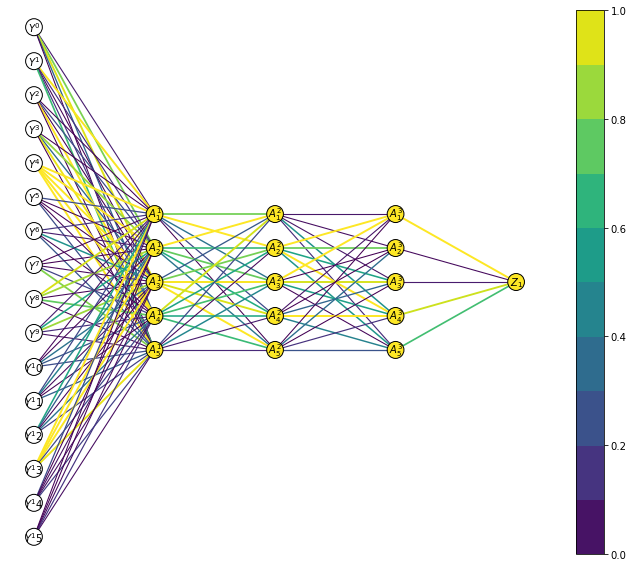

In [90]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")
cmap = "viridis"  # "Spectral_r"
draw_weighted_neural_net(
    ax,
    0.05,
    0.95,
    0.0,
    1.0,
    layer_dims,
    "Y",
    "A",
    "Z",
    10,
    node_wts=de_weights,
    edge_wts=de_weights,
    cmap=cmap,
)
sm, _ = get_rgb(0, cmap, 0, 1)
plt.colorbar(sm, boundaries=np.arange(0, 1.1, 0.1))

In [91]:
de_weights

[array([[0.12128511, 0.94295469, 0.05      , 0.05      , 0.94756371,
         0.26068343, 0.19018813, 0.05      , 0.8940877 , 0.13194908,
         0.06949966, 0.24115802, 0.58433786, 0.95      , 0.25571591,
         0.05972645],
        [0.769478  , 0.17772345, 0.25772577, 0.80938987, 0.95      ,
         0.05      , 0.11732478, 0.05      , 0.82756056, 0.58682282,
         0.05457834, 0.43464261, 0.31503592, 0.95      , 0.05      ,
         0.05574373],
        [0.90314143, 0.05      , 0.05011836, 0.35649319, 0.95      ,
         0.05335566, 0.50611429, 0.07010291, 0.05742646, 0.81721054,
         0.39190231, 0.07442059, 0.05      , 0.9430173 , 0.09139846,
         0.07406991],
        [0.34480406, 0.18772092, 0.95      , 0.92088149, 0.94818006,
         0.05      , 0.05      , 0.22781932, 0.73130316, 0.16489065,
         0.29861335, 0.05      , 0.391523  , 0.24618151, 0.08264499,
         0.19042366],
        [0.05      , 0.66518493, 0.05      , 0.05      , 0.95      ,
         0.2604

# Summarize Results

In [92]:
de_AL = nn.linear_forward(Ysimd, de_params, afunc)
de_AL_i, ivars = indicator_transform(de_AL, thresholds.values())

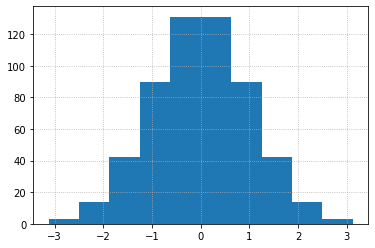

In [93]:
_ = plt.hist(de_AL)

## Variograms

In [94]:
xvario = update_variogram(de_AL, xlag_dict)
yvario = update_variogram(de_AL, ylag_dict)

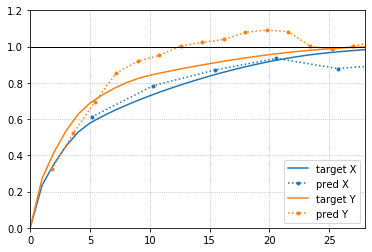

In [95]:
fig, ax = plt.subplots()
ax.plot(target_x, c="C0", label="target X")
ax.plot(xbins, xvario, c="C0", ls=":", marker=".", label="pred X")
ax.plot(target_y, c="C1", label="target Y")
ax.plot(ybins, yvario, c="C1", ls=":", marker=".", label="pred Y")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.5)
ax.legend()

In [96]:
igx = update_variogram(de_AL_i[:, 2], xlag_dict)  # / ivars[0]
igx

array([0.06860776, 0.08531022, 0.09022556, 0.10072314, 0.09539249,
       0.08873907, 0.10331633])

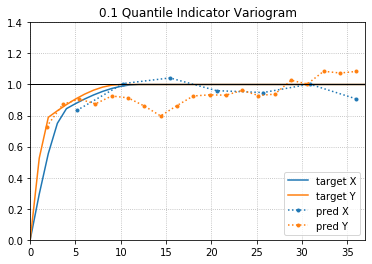

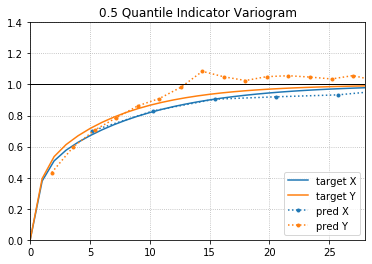

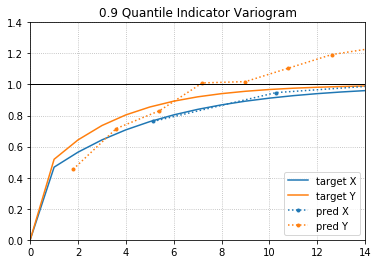

In [97]:
xscale = [0.66, 0.5, 0.25]
for j, q in enumerate(quantiles):
    fig, ax = plt.subplots()
    igx = update_variogram(de_AL_i[:, j], xlag_dict) / ivars[j]
    igy = update_variogram(de_AL_i[:, j], ylag_dict) / ivars[j]
    ax.plot(ivarios[q][0], c="C0", label="target X")
    ax.plot(ivarios[q][1], c="C1", label="target Y")
    ax.plot(xbins, igx, c="C0", ls=":", marker=".", label="pred X")
    ax.plot(ybins, igy, c="C1", ls=":", marker=".", label="pred Y")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.4)
    ax.set_xlim(0, nx * xscale[j])
    ax.legend()

 ## Runs

In [98]:
# for j, q in enumerate(thresholds):
#     fig, ax = plt.subplots()
#     target_cruns = np.sort(target_runs[q])
#     cruns = binary_runs(de_AL_i[:, j], runs_above=True)["cum_runs"]
#     cruns, _ = init_ecdf(cruns, wts=None, nhist=nhist)
#     pvals = [i / (nhist + 1) for i in range(1, nhist + 1)]
#     ax.plot(target_cruns, pvals, label="target CDF")
#     ax.plot(cruns, pvals, ls=":", c="C0", label="pred CDF")
#     ax.set_title(f"{q} Quantile")
#     ax.legend(loc=4)

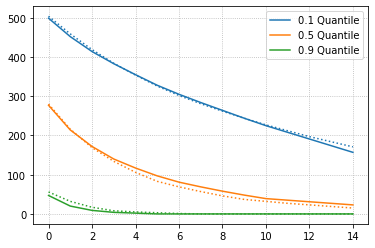

In [99]:
fig, ax = plt.subplots()
for j, q in enumerate(thresholds):
    X = de_AL_i[:, j].reshape(ncomps, ndh, order="F")
    temp_runs = np.zeros(maxrun)
    for n in range(ndh):
        run_freqs = binary_runs(X[:, n], runs_above)["cum_runs_freqs"][:maxrun]
        temp_runs += np.pad(run_freqs, (0, maxrun - len(run_freqs)))

    ax.plot(global_runs[q], c=f"C{j}", label=f"{q} Quantile")
    ax.plot(temp_runs, c=f"C{j}", ls=":")
ax.legend()

## n-Point Connectivity

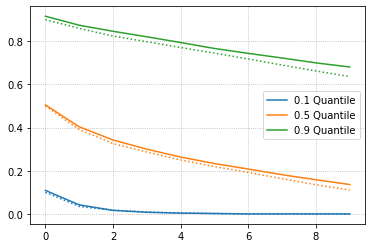

In [100]:
for j, q in enumerate(thresholds):
    npoint = n_pt_conn(
        de_AL_i[:, j].reshape(ncomps, ndh, order="F"), nstep=nstep
    )
    plt.plot(target_npoint[q], c=f"C{j}", label=f"{q} Quantile")
    plt.plot(npoint, c=f"C{j}", ls=":")
    plt.legend()

# Mix Gridded Factors

In [101]:
AL_grid = nn.linear_forward(Ysim, de_params, afunc)

In [102]:
AL_grid.shape

(3136,)

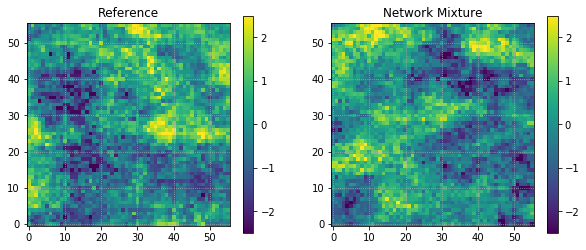

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
origin = "lower"
vmin = -2.5
vmax = 2.5
im0 = axes[0].imshow(reference, origin=origin, vmin=vmin, vmax=vmax)
axes[0].set_title("Reference")
im1 = axes[1].imshow(
    AL_grid.reshape(ny, nx), origin=origin, vmin=vmin, vmax=vmax
)
axes[1].set_title("Network Mixture")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])